In [ ]:
from google.colab import files

In [ ]:
# Upload the INDIA_685.csv file here by running this cell

uploaded1 = files.upload()

Saving INDIA_685.csv to INDIA_685.csv


In [ ]:
# Upload the sequences.fasta file here by running this cell

uploaded2 = files.upload()

Saving sequences.fasta to sequences.fasta


In [ ]:
!pip3 install biopython

     |████████████████████████████████| 2.3 MB 7.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from Bio import SeqIO

In [ ]:
data = pd.read_csv("INDIA_685.csv")
data.tail()

,StrainID,Accession_ID,Location,State,Host,Gender,Patient age,Patient status,Collection_date,Originating lab,Authors,Nuc_muts
680,hCoV-19/India/nimh-2873/2020|EPI_ISL_436137|20...,EPI_ISL_436137,Asia / India / Karnataka,Karnataka,Human,Female,28,Asymptomatic,21/04/2020,District Surveillance Unit,"Chitra Pattabiraman, Vijayalakshmi Reddy, Hars...","['C1281T', 'C4158T', 'G11083T', 'C13730T', 'C2..."
681,hCoV-19/India/nimh-3952/2020|EPI_ISL_436138|20...,EPI_ISL_436138,Asia / India / Karnataka,Karnataka,Human,Male,38,Asymptomatic,23/04/2020,District Surveillance Unit,"Chitra Pattabiraman, Vijayalakshmi Reddy, Hars...","['C241T', 'C3037T', 'C3634T', 'A3742G', 'C1440..."
682,hCoV-19/India/nimh-3970/2020|EPI_ISL_436139|20...,EPI_ISL_436139,Asia / India / Karnataka,Karnataka,Human,Male,20,Symptomatic,23/04/2020,District Surveillance Unit,"Chitra Pattabiraman, Vijayalakshmi Reddy, Hars...","['C241T', 'C3037T', 'C3634T', 'A3742G', 'C1440..."
683,hCoV-19/India/nimh-4376/2020|EPI_ISL_436140|20...,EPI_ISL_436140,Asia / India / Karnataka,Karnataka,Human,Female,52,Asymptomatic,24/04/2020,District Surveillance Unit,"Chitra Pattabiraman, Vijayalakshmi Reddy, Hars...","['C241T', 'C3037T', 'C3634T', 'A3742G', 'C1440..."
684,hCoV-19/India/nimh-4378/2020|EPI_ISL_436141|20...,EPI_ISL_436141,Asia / India / Karnataka,Karnataka,Human,Female,27,Asymptomatic,24/04/2020,District Surveillance Unit,"Chitra Pattabiraman, Vijayalakshmi Reddy, Hars...","['C241T', 'C3037T', 'C3634T', 'A3742G', 'C1440..."


In [ ]:
fasta_sequences = SeqIO.parse(open("sequences.fasta"),'fasta')

counter = 0
for fasta in fasta_sequences:
    counter +=1
    
print("Number of sequences is:", counter)    

Number of sequences is: 685


In [ ]:
def calc_score(examplesequence):

    position = 0
    score = 0
    value = 0
    flag = 0
    
    for base in examplesequence:

        if(base == "A" or base == "a"):
            value = 0
        elif(base == "G" or base == "g"):
            value = 1
        elif(base == "T" or base == "t"):
            value = 2
        elif(base == "C" or base == "c"):
            value = 3
        else:
            flag=1

        score += (4 ** position)* value
        position+=1

    return (flag,score)
    
calc_score("ATAGTAG")

(0, 4680)

In [ ]:
k=7
big_matrix = []
sequences_name = []

fasta_sequences = SeqIO.parse(open("sequences.fasta"),'fasta')

for fasta in fasta_sequences:
    
    embedding = np.zeros(4**k, dtype=int)
    sequence = str(fasta.seq)
    sequence_name = fasta.id
    sequences_name.append(sequence_name)

    for j in range(len(sequence)-k+1):
        kmer = sequence[j:j+k]
        flag,score = calc_score(kmer)
        if(flag!=1):
            embedding[score]+=1

    embedding = embedding.tolist()
    big_matrix.append(embedding)

In [ ]:
print("Number of sequences:", len(sequences_name))
print("Number of features for each sequence:", len(big_matrix[0]))

Number of sequences: 685
Number of features for each sequence: 16384


In [ ]:
from sklearn.decomposition import PCA

pca = PCA() # create a PCA object
pca.fit(big_matrix) # do the math
pca_data = pca.transform(big_matrix) # get PCA coordinates for the matrix

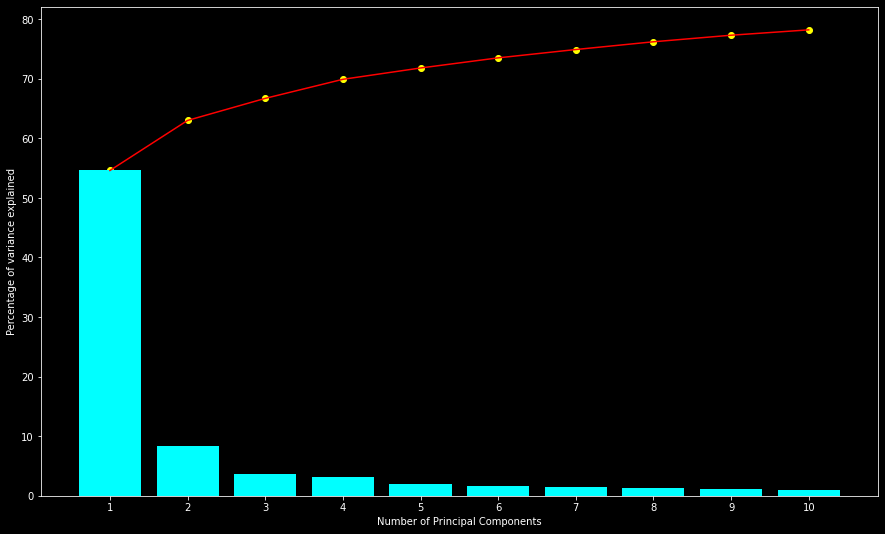

In [ ]:
import matplotlib.pyplot as plt

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels_all = ['PC'+str(x) for x in range(1, len(per_var)+1)]
per_var=per_var[:10]
labels = [str(x) for x in range(1, len(per_var)+1)]

with plt.style.context('dark_background'):
    plt.figure(figsize = (15, 9))
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Percentage of variance explained")
    plt.bar(range(1,len(per_var)+1), per_var, tick_label=labels, color = "aqua")
    plt.plot(range(1,len(per_var)+1), np.cumsum(per_var), color = "red")
    plt.scatter(range(1,len(per_var)+1), np.cumsum(per_var), color = "yellow")

In [ ]:
final_df = pd.DataFrame(columns=["StrainID", "PC1", "PC2", "PC3", "State"])
pca_df = pd.DataFrame(pca_data, index=[*sequences_name], columns = labels_all)

for sample in pca_df.index:
    
    dicti = dict()
    
    dicti["StrainID"] = sample
    dicti["PC1"] = pca_df.PC1.loc[sample]
    dicti["PC2"] = pca_df.PC2.loc[sample]
    dicti["PC3"] = pca_df.PC3.loc[sample]
    dicti["State"] = data[data["StrainID"]==sample]["State"].tolist()[0]
    
    final_df = final_df.append(dicti, ignore_index = True)

final_df.head()

,StrainID,PC1,PC2,PC3,State
0,hCoV-19/India/763/2020|EPI_ISL_420543|2020-03-03,-4.326235,-3.484139,-1.786329,Stateless
1,hCoV-19/India/770/2020|EPI_ISL_420545|2020-03-03,-4.234399,-3.509996,-1.804263,Stateless
2,hCoV-19/India/772/2020|EPI_ISL_420547|2020-03-03,-4.184090,-3.754896,-1.696688,Stateless
3,hCoV-19/India/773/2020|EPI_ISL_420549|2020-03-03,-4.194559,-3.531680,-1.895380,Stateless
4,hCoV-19/India/777/2020|EPI_ISL_420551|2020-03-03,-4.186462,-3.550434,-1.888697,Stateless


In [ ]:
import plotly.graph_objs as go
import plotly.express as px

In [ ]:
for_x = final_df.PC1.tolist()
for_y = final_df.PC2.tolist()
for_states = final_df.State.tolist()
for_hover = final_df.StrainID.tolist()

fig = px.scatter(x=for_x, y=for_y, color=for_states, title="Principal Component Axis",
                color_discrete_map={
                "Stateless": "grey",
                "Tamil Nadu": "green",
                "Telangana": "red",
                "Maharashtra": "orange",
                "Gujarat": "magenta",
                "Delhi": "purple",
                "West Bengal": "aqua",
                "Haryana": "pink",
                "Odisha": "blue",
                "Madhya Pradesh": "brown",
                "Karnataka": "black"
                })

fig.show(renderer = "colab")

In [ ]:
from sklearn.manifold import TSNE

# Use these parameters
random_state = 0
n_components = 2
perplexity = 30
n_iter = 10000

####### Enter code below ####### 

# model = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, n_iter=n_iter)
# tsne_data = model.fit_transform(big_matrix)

################################

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
final_df = pd.DataFrame(columns=["StrainID", "X", "Y", "State"])
pca_df = pd.DataFrame(pca_data, index=[*sequences_name], columns = labels_all)

i = 0
for sample in pca_df.index:
    
    dicti = dict()
    
    dicti["StrainID"] = sample
    dicti["X"] = tsne_data[i][0]
    dicti["Y"] = tsne_data[i][1]
    dicti["State"] = data[data["StrainID"]==sample]["State"].tolist()[0]
    
    final_df = final_df.append(dicti, ignore_index = True)
    i+=1

final_df.tail()

,StrainID,X,Y,State
680,hCoV-19/India/MaxCov0046_CSIR-IGIB/2020|EPI_IS...,1.881189,11.271591,Delhi
681,hCoV-19/India/MaxCov0047_CSIR-IGIB/2020|EPI_IS...,1.828764,11.692644,Delhi
682,hCoV-19/India/MaxCov0048_CSIR-IGIB/2020|EPI_IS...,1.750070,12.592662,Delhi
683,hCoV-19/India/MaxCov0049_CSIR-IGIB/2020|EPI_IS...,1.364001,12.977669,Delhi
684,hCoV-19/India/MaxCov0050_CSIR-IGIB/2020|EPI_IS...,2.358655,10.985281,Delhi


In [ ]:
for_x = final_df.X.tolist()
for_y = final_df.Y.tolist()
for_states = final_df.State.tolist()
for_hover = final_df.StrainID.tolist()

fig = px.scatter(x=for_x, y=for_y, color=for_states, title="t-SNE", height=600, width=1000,
                color_discrete_map={
                "Stateless": "grey",
                "Tamil Nadu": "green",
                "Telangana": "red",
                "Maharashtra": "orange",
                "Gujarat": "magenta",
                "Delhi": "purple",
                "West Bengal": "aqua",
                "Haryana": "pink",
                "Odisha": "blue",
                "Madhya Pradesh": "brown",
                "Karnataka": "black"})

fig.show(renderer = 'colab')

In [ ]:
## First we need to get the list of all unique mutations observed in our dataset.

mutations = []
for i in range(len(data)):

    sample_muts = data["Nuc_muts"][i][1:][:-1].split(",")

    for j in sample_muts:
        mut = j.strip()[1:][:-1]
        if(len(mut)>=2):
            if(mut not in mutations):
                mutations.append(mut)

print(len(mutations))

1279


So there are 1279 unique mutations in our sequences. We can now represent each genome as a ```vector of size 1279 where each position indicates the presence (1) or absence (0) of a specific mutation```.

In [ ]:
samplelist = data["StrainID"].tolist()
df = pd.DataFrame(columns = [*samplelist])
df = df.replace(np.nan,0)

for mutation in mutations:

    dicti = dict(zip(samplelist, np.zeros(len(samplelist), dtype=int)))

    for i in range(len(data)):
        flag=0
        strainid = data["StrainID"][i]
        sample_muts = data["Nuc_muts"][i][1:][:-1].split(",")

        for j in sample_muts:
            mut = j.strip()[1:][:-1]
            if(len(mut)>=2):
                if(mut == mutation):
                    flag = 1
                    break

        dicti[strainid]=flag  

    df = df.append(dicti, ignore_index = True)
    
df = df.T

df.tail()

,0,1,2,3,4,5,6,7,8,9,...,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278
hCoV-19/India/nimh-2873/2020|EPI_ISL_436137|2020-04-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
hCoV-19/India/nimh-3952/2020|EPI_ISL_436138|2020-04-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
hCoV-19/India/nimh-3970/2020|EPI_ISL_436139|2020-04-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
hCoV-19/India/nimh-4376/2020|EPI_ISL_436140|2020-04-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
hCoV-19/India/nimh-4378/2020|EPI_ISL_436141|2020-04-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [ ]:
pca = PCA()
pca.fit(df)
pca_data = pca.transform(df)

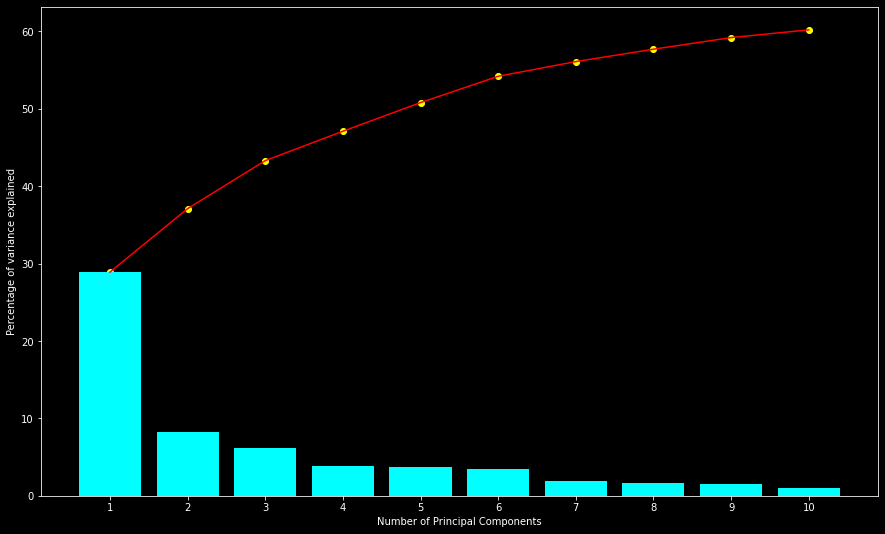

In [ ]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels_all = ['PC'+str(x) for x in range(1, len(per_var)+1)]
per_var=per_var[:10]
labels = [str(x) for x in range(1, len(per_var)+1)]

with plt.style.context('dark_background'):
    plt.figure(figsize = (15, 9))
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Percentage of variance explained")
    plt.bar(range(1,len(per_var)+1), per_var, tick_label=labels, color = "aqua")
    plt.plot(range(1,len(per_var)+1), np.cumsum(per_var), color = "red")
    plt.scatter(range(1,len(per_var)+1), np.cumsum(per_var), color = "yellow")

The first principal component should be able to capture close to 30% of the variance in the dataset.

In [ ]:
final_df = pd.DataFrame(columns=["StrainID", "PC1", "PC2", "State"])
pca_df = pd.DataFrame(pca_data, index=[*samplelist], columns = labels_all)

for sample in pca_df.index:
    
    dicti = dict()
    
    dicti["StrainID"] = sample
    dicti["PC1"] = pca_df.PC1.loc[sample]
    dicti["PC2"] = pca_df.PC2.loc[sample]
    dicti["State"] = data[data["StrainID"]==sample]["State"].tolist()[0]
    
    final_df = final_df.append(dicti, ignore_index = True)

final_df.tail()

,StrainID,PC1,PC2,State
680,hCoV-19/India/nimh-2873/2020|EPI_ISL_436137|20...,1.530221,0.079550,Karnataka
681,hCoV-19/India/nimh-3952/2020|EPI_ISL_436138|20...,-1.063943,-0.405022,Karnataka
682,hCoV-19/India/nimh-3970/2020|EPI_ISL_436139|20...,-1.058232,-0.410670,Karnataka
683,hCoV-19/India/nimh-4376/2020|EPI_ISL_436140|20...,-1.057465,-0.409620,Karnataka
684,hCoV-19/India/nimh-4378/2020|EPI_ISL_436141|20...,-1.057465,-0.409620,Karnataka


In [ ]:
for_x = final_df.PC1.tolist()
for_y = final_df.PC2.tolist()
for_states = final_df.State.tolist()
for_hover = final_df.StrainID.tolist()

fig = px.scatter(x=for_x, y=for_y, color=for_states, height=600, width=1200,
                 title="Principal Component Axis",
                color_discrete_map={
                "Stateless": "grey",
                "Tamil Nadu": "green",
                "Telangana": "red",
                "Maharashtra": "orange",
                "Gujarat": "magenta",
                "Delhi": "purple",
                "West Bengal": "aqua",
                "Haryana": "pink",
                "Odisha": "blue",
                "Madhya Pradesh": "brown",
                "Karnataka": "black"})
fig.show(renderer = 'colab')